# Analyses of fingerprints

In [1]:
prefix = '/home/ines/repositories/'
# prefix = '/Users/ineslaranjeira/Documents/Repositories/'

In [2]:
""" 
IMPORTS
"""
import os
import numpy as np
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# --Machine learning and statistics

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler,  LabelBinarizer
import umap
from sklearn import mixture
import pickle
from scipy.stats import mode
from sklearn.metrics.pairwise import pairwise_distances
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import cosine
from sklearn.decomposition import PCA
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.spatial import distance_matrix, distance
import itertools

# Get my functions
functions_path =  prefix + 'representation_learning_variability/Functions/'
os.chdir(functions_path)
# from data_processing import save_and_log
functions_path =  prefix + 'representation_learning_variability/Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
from preprocessing_functions import idxs_from_files
functions_path =  prefix + 'representation_learning_variability/Models/Sub-trial/4_analyses/5_clustering_analyses/'
os.chdir(functions_path)
# from clustering_functions import calculate_entropy
functions_path =  prefix + 'representation_learning_variability/Models/Sub-trial//3_postprocess_results/'
os.chdir(functions_path)
from plotting_functions import create_grouped_gradient_palette
from one.api import ONE
one = ONE(mode='remote')

In [14]:
data_path = prefix + 'representation_learning_variability/paper-individuality/fig1_segmentation/'
filename = str(data_path + 'all_sequences_11-20-2025')
all_sequences = pd.read_parquet(filename)

data_path = prefix + 'representation_learning_variability/paper-individuality/fig4_clustering/'
cluster_df = pd.read_parquet(data_path+'5_cluster_per_session_11-20-2025')
cluster_df = pd.read_parquet(data_path+'6_cluster_per_session_kmeans')

In [15]:
def create_mapping(strings, order):

    strings_sorted = sorted(strings, key=lambda s: tuple(int(s[i]) for i in order))

    identifiable_mapping = {
        s: float(i) for i, s in enumerate(strings_sorted)
    }
    
    return identifiable_mapping


def compress_d2_d3(d2, d3):
    if d2 == "0" and d3 == "0":
        return "0"
    if d2 in ("1", "2") and d3 == "0":
        return "1"
    if d2 == "0" and d3 in ("1", "2"):
        return "2"
    if d2 in ("1", "2") and d3 in ("1", "2"):
        return "3"
    raise ValueError(f"Unexpected values d2={d2}, d3={d3}")

# def compress_d2_d3(d2, d3):
#     if d2 == "0" and d3 == "0":
#         return "0"
#     if d2 in ("0", "1") and d3 == "2":
#         return "2"
#     if d2 == "2" and d3 in ("1", "0"):
#         return "1"
#     if d2 in ("1", "2") and d3 in ("1", "2"):
#         return "3"
#     raise ValueError(f"Unexpected values d2={d2}, d3={d3}")

def compress_code_5_to_4(code):
    # code is a 5-character string like "01210"
    d0 = code[0]
    d1 = code[1]
    d2 = code[2]
    d3 = code[3]
    d4 = code[4]
    
    new_d12 = compress_d2_d3(d1, d2)
    
    return f"{d0}{new_d12}{d3}{d4}"


In [16]:
ranges = {
    0: [0,1,2],
    1: [0,1,2],
    2: [0,1,2],
    3: [0,1],
    4: [0,1],
}
# generate all strings
original_strings = [
    f"{d0}{d1}{d2}{d3}{d4}"
    for d0, d1, d2, d3, d4 in itertools.product(
        ranges[0], ranges[1], ranges[2], ranges[3], ranges[4]
    )
]

# custom sort: using order 1,2,3,4,0
order = [1,2,3,4,0]
identifiable_mapping = create_mapping(original_strings, order)
inverted_mapping = {v: k for k, v in identifiable_mapping.items()}

compressed_strings = list(np.unique(pd.Series(original_strings).apply(compress_code_5_to_4)))
order = [1,2,3,0]
comp_identifiable_mapping = create_mapping(compressed_strings, order)
inverted_comp_mapping = {v: k for k, v in comp_identifiable_mapping.items()}

In [17]:
def expand_from_trial_type(df):
    
    df['feedback'] = df['trial_type'].str.split().str[:1].str.join('')
    df['choice'] = df['trial_type'].str.split().str[3:4].str.join('')
    df['block'] = df['trial_type'].str.split().str[2:3].str.join('')
    df['contrast'] = df['trial_type'].str.split().str[1:2].str.join('')
    df['side'] = df['choice'].copy()
    df.loc[(df['feedback']=='correct') & (df['choice']=='right'), 'side'] = 'left'
    df.loc[(df['feedback']=='correct') & (df['choice']=='left'), 'side'] = 'right'
    df['session'] = df['sample'].str.split().str[:1].str.join('')
    df['trial_id'] = df['sample'].str.split().str[1:2].str.join('')
    df['contrast'] = df['contrast'].astype(float)
    df['block'] = df['block'].astype(float)
    df['choice'] = df['trial_type'].str.split().str[3:4].str.join('')
    df.loc[df['choice']=='left', 'choice'] = 0
    df.loc[df['choice']=='right', 'choice'] = 1
    df.loc[df['feedback']=='correct', 'feedback'] = 1
    df.loc[df['feedback']=='incorrect', 'feedback'] = 0
    
    return df

def group_by_var_interest(session_syllables, var_interest, use_states, binarized):

    session_syllables = session_syllables.groupby(['mouse_name', 'session', 'session_cluster', var_interest])[np.arange(0, np.shape(binarized)[1], 1)].mean().reset_index()
    
    timesteps = 40
    reshaped_probs = pd.DataFrame()
    clusters = session_syllables['session_cluster'].copy()
    v_int = session_syllables[var_interest].copy()

    for i, interest in enumerate(np.unique(v_int)):
        for c, cluster in enumerate(np.unique(clusters)):
            reshaped_probs_cluster = pd.DataFrame(columns=['syllable', 'timestep', 'cluster', 'prob', var_interest], index=range(use_states * timesteps))
            indices = np.where((session_syllables['session_cluster']==cluster) & (session_syllables[var_interest]==interest))[0]
            syllable_prob = np.array(session_syllables[session_syllables.keys()[4:]])[indices, :].mean(axis=0)

            for t in range(timesteps):
                reshaped_probs_cluster['syllable'][t*use_states:(t+1)*use_states] = compressed_strings
                reshaped_probs_cluster['timestep'][t*use_states:(t+1)*use_states] = t
                reshaped_probs_cluster['prob'][t*use_states:(t+1)*use_states] = syllable_prob[t*use_states:(t+1)*use_states]
                reshaped_probs_cluster['cluster'][t*use_states:(t+1)*use_states] = cluster
                reshaped_probs_cluster[var_interest][t*use_states:(t+1)*use_states] = interest
            # Save
            reshaped_probs = pd.concat([reshaped_probs, reshaped_probs_cluster])
            
    return reshaped_probs

def group_by_cluster(session_syllables, use_states, binarized):

    session_syllables = session_syllables.groupby(['mouse_name', 'session', 'session_cluster'])[np.arange(0, np.shape(binarized)[1], 1)].mean().reset_index()
    
    timesteps = 40
    reshaped_probs = pd.DataFrame()
    clusters = session_syllables['session_cluster'].copy()

    for c, cluster in enumerate(np.unique(clusters)):
        reshaped_probs_cluster = pd.DataFrame(columns=['syllable', 'timestep', 'cluster', 'prob'], index=range(use_states * timesteps))
        indices = np.where((session_syllables['session_cluster']==cluster))[0]
        syllable_prob = np.array(session_syllables[session_syllables.keys()[3:]])[indices, :].mean(axis=0)

        for t in range(timesteps):
            reshaped_probs_cluster['syllable'][t*use_states:(t+1)*use_states] = compressed_strings
            reshaped_probs_cluster['timestep'][t*use_states:(t+1)*use_states] = t
            reshaped_probs_cluster['prob'][t*use_states:(t+1)*use_states] = syllable_prob[t*use_states:(t+1)*use_states]
            reshaped_probs_cluster['cluster'][t*use_states:(t+1)*use_states] = cluster
        # Save
        reshaped_probs = pd.concat([reshaped_probs, reshaped_probs_cluster])
            
    return reshaped_probs


def group_by_session(session_syllables, use_states, binarized):

    session_syllables = session_syllables.groupby(['mouse_name', 'session', 'session_cluster'])[np.arange(0, np.shape(binarized)[1], 1)].mean().reset_index()
    
    timesteps = 40
    reshaped_probs = pd.DataFrame()
    # clusters = session_syllables['session_cluster'].copy()
    sessions = session_syllables['session'].copy()

    for s, session in enumerate(np.unique(sessions)):
        reshaped_probs_cluster = pd.DataFrame(columns=['syllable', 'timestep', 'session', 'prob'], index=range(use_states * timesteps))
        indices = np.where((session_syllables['session']==session))[0]
        syllable_prob = np.array(session_syllables[session_syllables.keys()[3:]])[indices, :].sum(axis=0)

        for t in range(timesteps):
            reshaped_probs_cluster['syllable'][t*use_states:(t+1)*use_states] = compressed_strings
            reshaped_probs_cluster['timestep'][t*use_states:(t+1)*use_states] = t
            reshaped_probs_cluster['prob'][t*use_states:(t+1)*use_states] = syllable_prob[t*use_states:(t+1)*use_states]
            reshaped_probs_cluster['session'][t*use_states:(t+1)*use_states] = session
        # Save
        reshaped_probs = pd.concat([reshaped_probs, reshaped_probs_cluster])
            
    return reshaped_probs


In [18]:
complete_df = expand_from_trial_type(all_sequences)
del all_sequences
complete_df = complete_df.merge(cluster_df[['mouse_name', 'session', 'session_cluster']], on=['mouse_name', 'session'])
# complete_df = complete_df.merge(trial_clusters_df[['mouse_name', 'session', 'trial_id', 'trial_cluster']], on=['mouse_name', 'session', 'trial_id'])

In [19]:
var_interest = 'block'
var_interest = ''
if len(var_interest) > 0:
    pivoted_df = complete_df.pivot(index=['sample', 'trial_type', 'mouse_name', 'session', var_interest], columns=['broader_label'], values='binned_sequence').reset_index().dropna()
else:
    pivoted_df = complete_df.pivot(index=['sample', 'trial_type', 'mouse_name', 'session'], columns=['broader_label'], values='binned_sequence').reset_index().dropna()
pivoted_df = pivoted_df.merge(cluster_df[['mouse_name', 'session', 'session_cluster']], on=['mouse_name', 'session'])

del complete_df

In [20]:
epoch_to_analyse = ['Pre-quiescence', 'Quiescence', 'Choice', 'ITI']

sequences_choice = np.vstack(pivoted_df[epoch_to_analyse].apply(lambda row: np.hstack(row), axis=1))  # Transpose to get the right shape
use_sequences = sequences_choice[~np.isnan(sequences_choice).any(axis=1)]



# Integer to string
replace_func = np.vectorize(inverted_mapping.get)
string_form = replace_func(use_sequences)
# String compression
vectorized_compress = np.vectorize(compress_code_5_to_4)
compressed_codes = vectorized_compress(string_form)
# String to integer
replace_func = np.vectorize(comp_identifiable_mapping.get)
use_sequences = replace_func(compressed_codes)




use_states = int(max(np.unique(use_sequences)))+1
timesteps = np.shape(use_sequences)[1]
binarized = np.zeros((np.shape(use_sequences)[0], timesteps*use_states))

for t in range(timesteps):
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(range(use_states))
    encoded_arr = label_binarizer.transform(use_sequences[:, t])
    binarized[:, t*use_states:(t+1)*use_states] = encoded_arr

# final_matrix = binarized.copy()


In [21]:

session_syllables = pd.DataFrame(binarized)
session_syllables['session'] = pivoted_df['session'].copy()
session_syllables['session_cluster'] = pivoted_df['session_cluster'].copy()
session_syllables['mouse_name'] = pivoted_df['mouse_name'].copy()
use_states = len(np.unique(use_sequences))

if len(var_interest) > 0:
    session_syllables[var_interest] = pivoted_df[var_interest].copy()
    reshaped_probs = group_by_var_interest(session_syllables, var_interest, use_states, binarized)
else:
    reshaped_probs = group_by_cluster(session_syllables, use_states, binarized)
    # reshaped_counts = group_by_session(session_syllables, use_states, binarized)
clusters = cluster_df['session_cluster']

/tmp/ipykernel_9839/2028599425.py:62: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  reshaped_probs_cluster['syllable'][t*use_states:(t+1)*use_states] = compressed_strings
/tmp/ipykernel_9839/2028599425.py:63: FutureWarning: ChainedAssignment

## Plot overall trends

In [22]:
palette = sns.light_palette("seagreen", 5, as_cmap=False)[1:]

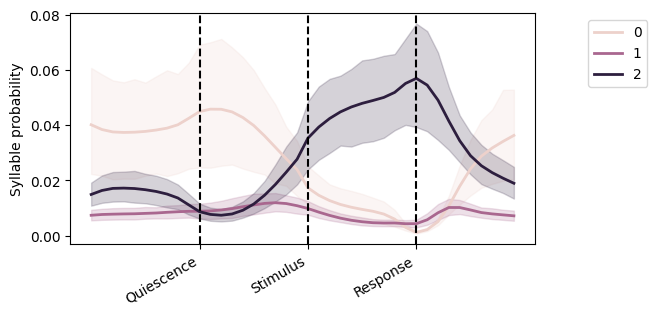

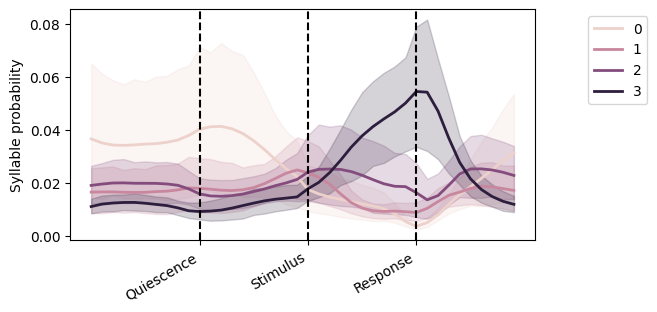

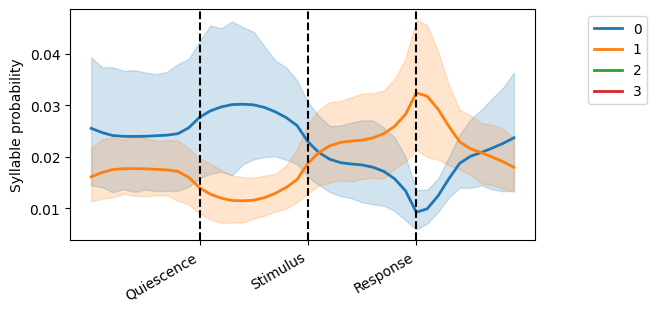

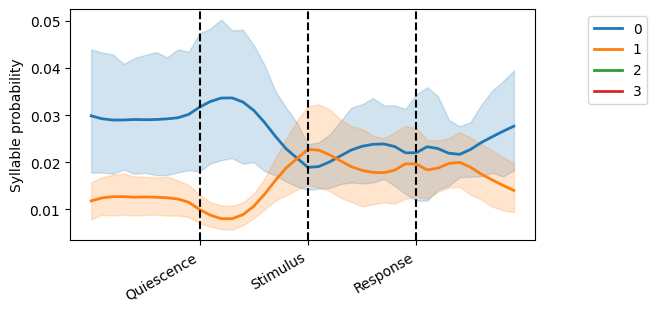

In [23]:
for i in range(4):
    fig, axs = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(6, 3))

    use_data = reshaped_probs.copy()
    use_data['plot'] = use_data["syllable"].str[i].astype(int)

    # use_data['syllable'] = rename_func(use_data['syllable'])
    # use_syllables = paw_syllable[i]
    # use_data = use_data.loc[use_data['syllable'].isin(use_syllables)]
    sns.lineplot(x='timestep', y='prob', hue='plot', data=use_data, 
                ax=axs,  linewidth=2, hue_order=[0, 1, 2, 3])  #  legend=labels[c]  style=var_interest,

    axs.axvline(x=10, color='k', linestyle='--')
    axs.axvline(x=20, color='k', linestyle='--')
    axs.axvline(x=30, color='k', linestyle='--')
    axs.set_ylabel('Syllable probability')
    axs.set_xlabel('')
    # axs[c].set_ylim([0, 0.85])
    axs.set_xticks(np.arange(10, 31, 10), ['Quiescence', 'Stimulus', 'Response'], rotation=30, ha='right')
    axs.legend('')
    axs.legend(loc='upper left', bbox_to_anchor=(1.1, 1))

/tmp/ipykernel_9839/3231681391.py:12: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.lineplot(x='timestep', y='prob', hue='plot', data=use_data,
/tmp/ipykernel_9839/3231681391.py:12: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.lineplot(x='timestep', y='prob', hue='plot', data=use_data,
/tmp/ipykernel_9839/3231681391.py:12: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.lineplot(x='timestep', y='prob', hue='plot', data=use_data,
/tmp/ipykernel_9839/3231681391.py:12: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.lineplot(x='timestep', y='prob', hue='plot', data=use_data,
/tmp/ipykernel_9839/3231681391.py:12: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.lineplot(x='timestep', y='prob', hue='plot', data=use_data,


IndexError: index 5 is out of bounds for axis 0 with size 5

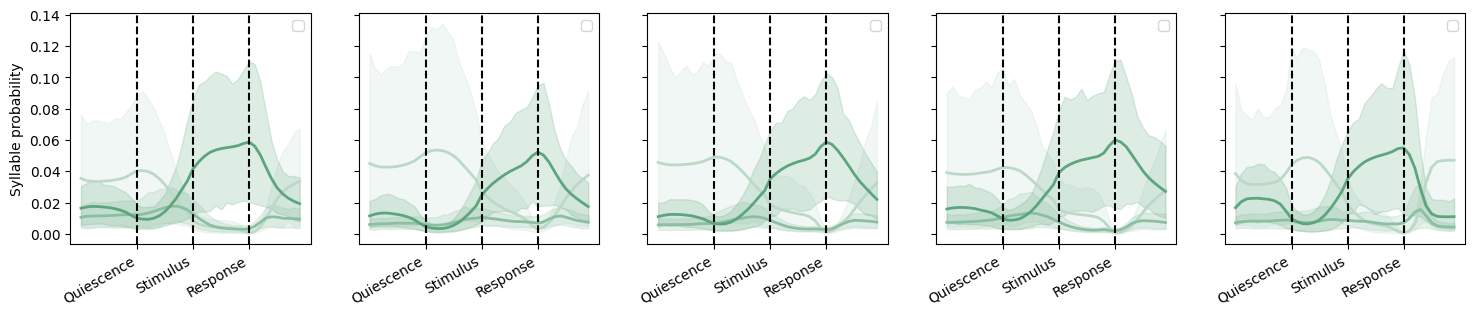

In [24]:
for i in range(4):
  fig, axs = plt.subplots(1, 5, sharex=True, sharey=True, figsize=(18, 3))

  for c, cluster in enumerate(np.unique(clusters)):
      use_data = reshaped_probs.loc[reshaped_probs['cluster']==cluster].reset_index()
      use_data['plot'] = use_data["syllable"].str[i].astype(int)

      
      # use_data['syllable'] = rename_func(use_data['syllable'])
      # use_syllables = paw_syllable[i]
      # use_data = use_data.loc[use_data['syllable'].isin(use_syllables)]
      sns.lineplot(x='timestep', y='prob', hue='plot', data=use_data, 
                  ax=axs[c], palette=palette, linewidth=2, hue_order=[0, 1, 2])  #  legend=labels[c]  style=var_interest,

      axs[c].axvline(x=10, color='k', linestyle='--')
      axs[c].axvline(x=20, color='k', linestyle='--')
      axs[c].axvline(x=30, color='k', linestyle='--')
      axs[c].set_ylabel('Syllable probability')
      axs[c].set_xlabel('')
      # axs[c].set_ylim([0, 0.85])
      axs[c].set_xticks(np.arange(10, 31, 10), ['Quiescence', 'Stimulus', 'Response'], rotation=30, ha='right')
      axs[c].legend('')
axs[c].legend(loc='upper left', bbox_to_anchor=(1.1, 1))

/tmp/ipykernel_13183/3646578788.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[c].legend(loc='upper left', bbox_to_anchor=(1.1, 1))


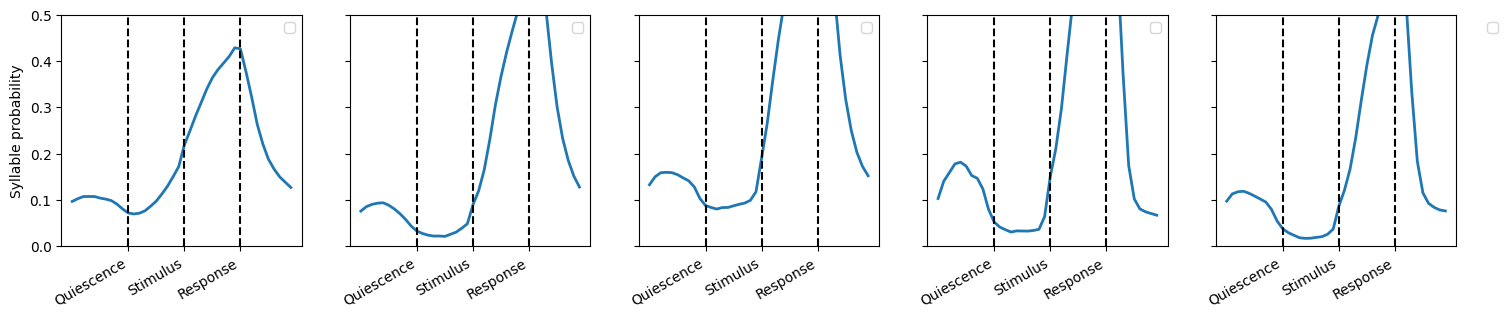

In [26]:
filtered = reshaped_probs[
    reshaped_probs["syllable"].str[0].astype(int).isin([1, 2]) &  # movement: 0, 1   ballistic 1
    reshaped_probs["syllable"].str[1].astype(int).isin([3])  # movement: 0, 2   ballistic 2
]
filtered = filtered.groupby(['timestep', 'cluster'])['prob'].sum().reset_index()

fig, axs = plt.subplots(1, 5, sharex=True, sharey=True, figsize=(18, 3))

for c, cluster in enumerate(np.unique(clusters)):
    use_data = filtered.loc[filtered['cluster']==cluster].reset_index()
    sns.lineplot(x='timestep', y='prob',  data=use_data, 
                ax=axs[c], linewidth=2)  #  legend=labels[c]  style=var_interest, hue='syllable',

    axs[c].axvline(x=10, color='k', linestyle='--')
    axs[c].axvline(x=20, color='k', linestyle='--')
    axs[c].axvline(x=30, color='k', linestyle='--')
    axs[c].set_ylabel('Syllable probability')
    axs[c].set_xlabel('')
    axs[c].set_ylim([0, 0.5])
    axs[c].set_xticks(np.arange(10, 31, 10), ['Quiescence', 'Stimulus', 'Response'], rotation=30, ha='right')
    axs[c].legend('')
axs[c].legend(loc='upper left', bbox_to_anchor=(1.1, 1))

/tmp/ipykernel_13183/3146956517.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[c].legend(loc='upper left', bbox_to_anchor=(1.1, 1))


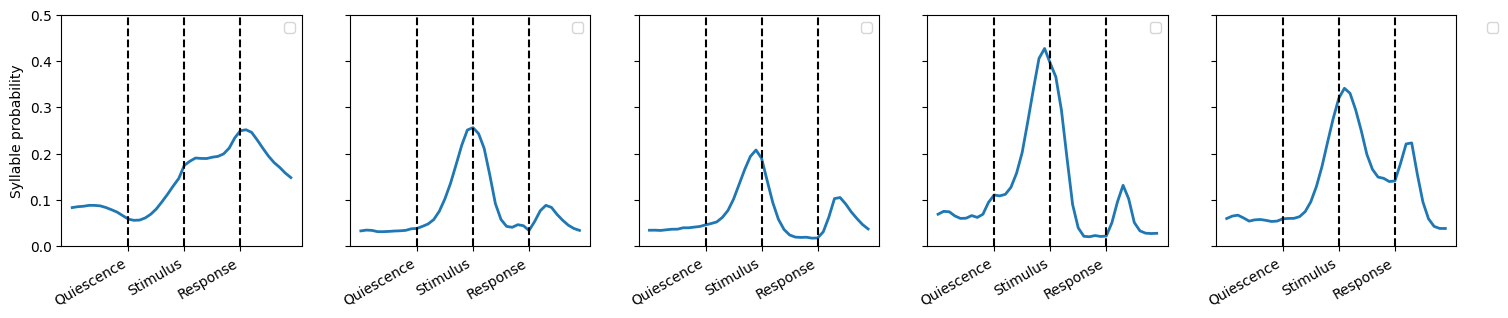

In [25]:
filtered = reshaped_probs[
    reshaped_probs["syllable"].str[0].astype(int).isin([1, 2]) &  # movement: 0, 1   ballistic 1
    reshaped_probs["syllable"].str[1].astype(int).isin([1])  # movement: 0, 2   ballistic 2
]
filtered = filtered.groupby(['timestep', 'cluster'])['prob'].sum().reset_index()

fig, axs = plt.subplots(1, 5, sharex=True, sharey=True, figsize=(18, 3))

for c, cluster in enumerate(np.unique(clusters)):
    use_data = filtered.loc[filtered['cluster']==cluster].reset_index()
    sns.lineplot(x='timestep', y='prob',  data=use_data, 
                ax=axs[c], linewidth=2)  #  legend=labels[c]  style=var_interest, hue='syllable',

    axs[c].axvline(x=10, color='k', linestyle='--')
    axs[c].axvline(x=20, color='k', linestyle='--')
    axs[c].axvline(x=30, color='k', linestyle='--')
    axs[c].set_ylabel('Syllable probability')
    axs[c].set_xlabel('')
    axs[c].set_ylim([0, 0.5])
    axs[c].set_xticks(np.arange(10, 31, 10), ['Quiescence', 'Stimulus', 'Response'], rotation=30, ha='right')
    axs[c].legend('')
axs[c].legend(loc='upper left', bbox_to_anchor=(1.1, 1))

/tmp/ipykernel_13183/997787872.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[c].legend(loc='upper left', bbox_to_anchor=(1.1, 1))


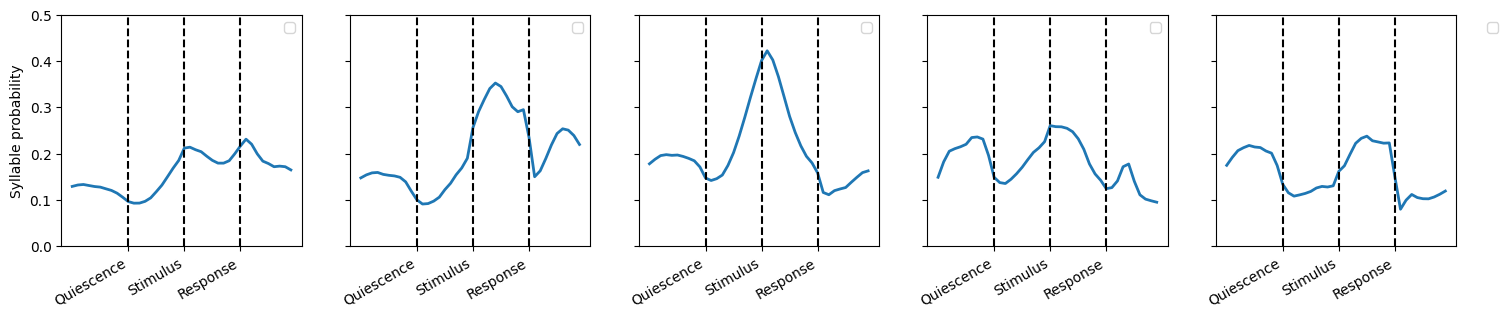

In [23]:
filtered = reshaped_probs[
    reshaped_probs["syllable"].str[0].astype(int).isin([1, 2]) &  # movement: 0, 1   ballistic 1
    reshaped_probs["syllable"].str[1].astype(int).isin([2])  # movement: 0, 2   ballistic 2
]
filtered = filtered.groupby(['timestep', 'cluster'])['prob'].sum().reset_index()

fig, axs = plt.subplots(1, 5, sharex=True, sharey=True, figsize=(18, 3))

for c, cluster in enumerate(np.unique(clusters)):
    use_data = filtered.loc[filtered['cluster']==cluster].reset_index()
    sns.lineplot(x='timestep', y='prob',  data=use_data, 
                ax=axs[c], linewidth=2)  #  legend=labels[c]  style=var_interest, hue='syllable',

    axs[c].axvline(x=10, color='k', linestyle='--')
    axs[c].axvline(x=20, color='k', linestyle='--')
    axs[c].axvline(x=30, color='k', linestyle='--')
    axs[c].set_ylabel('Syllable probability')
    axs[c].set_xlabel('')
    axs[c].set_ylim([0, 0.5])
    axs[c].set_xticks(np.arange(10, 31, 10), ['Quiescence', 'Stimulus', 'Response'], rotation=30, ha='right')
    axs[c].legend('')
axs[c].legend(loc='upper left', bbox_to_anchor=(1.1, 1))

In [14]:
def group_by_var_interest(session_syllables, var_interest, use_states, binarized):

    session_syllables = session_syllables.groupby(['mouse_name', 'session', 'session_cluster', var_interest])[np.arange(0, np.shape(binarized)[1], 1)].mean().reset_index()
    
    timesteps = 40
    reshaped_probs = pd.DataFrame()
    clusters = session_syllables['session_cluster'].copy()
    v_int = session_syllables[var_interest].copy()

    for i, interest in enumerate(np.unique(v_int)):
        for c, cluster in enumerate(np.unique(clusters)):
            reshaped_probs_cluster = pd.DataFrame(columns=['syllable', 'timestep', 'cluster', 'prob', var_interest], index=range(use_states * timesteps))
            indices = np.where((session_syllables['session_cluster']==cluster) & (session_syllables[var_interest]==interest))[0]
            syllable_prob = np.array(session_syllables[session_syllables.keys()[4:]])[indices, :].mean(axis=0)

            for t in range(timesteps):
                reshaped_probs_cluster['syllable'][t*use_states:(t+1)*use_states] = strings
                reshaped_probs_cluster['timestep'][t*use_states:(t+1)*use_states] = t
                reshaped_probs_cluster['prob'][t*use_states:(t+1)*use_states] = syllable_prob[t*use_states:(t+1)*use_states]
                reshaped_probs_cluster['cluster'][t*use_states:(t+1)*use_states] = cluster
                reshaped_probs_cluster[var_interest][t*use_states:(t+1)*use_states] = interest
            # Save
            reshaped_probs = pd.concat([reshaped_probs, reshaped_probs_cluster])
            
    return reshaped_probs

def group_by_cluster(session_syllables, use_states, binarized):

    session_syllables = session_syllables.groupby(['mouse_name', 'session', 'session_cluster'])[np.arange(0, np.shape(binarized)[1], 1)].mean().reset_index()
    
    timesteps = 40
    reshaped_probs = pd.DataFrame()
    clusters = session_syllables['session_cluster'].copy()

    for c, cluster in enumerate(np.unique(clusters)):
        reshaped_probs_cluster = pd.DataFrame(columns=['syllable', 'timestep', 'cluster', 'prob'], index=range(use_states * timesteps))
        indices = np.where((session_syllables['session_cluster']==cluster))[0]
        syllable_prob = np.array(session_syllables[session_syllables.keys()[3:]])[indices, :].mean(axis=0)

        for t in range(timesteps):
            reshaped_probs_cluster['syllable'][t*use_states:(t+1)*use_states] = strings
            reshaped_probs_cluster['timestep'][t*use_states:(t+1)*use_states] = t
            reshaped_probs_cluster['prob'][t*use_states:(t+1)*use_states] = syllable_prob[t*use_states:(t+1)*use_states]
            reshaped_probs_cluster['cluster'][t*use_states:(t+1)*use_states] = cluster
        # Save
        reshaped_probs = pd.concat([reshaped_probs, reshaped_probs_cluster])
            
    return reshaped_probs


def group_by_cluster(session_syllables, use_states, binarized):

    session_syllables = session_syllables.groupby(['mouse_name', 'session', 'session_cluster'])[np.arange(0, np.shape(binarized)[1], 1)].mean().reset_index()
    
    timesteps = 40
    reshaped_probs = pd.DataFrame()
    clusters = session_syllables['session_cluster'].copy()

    for c, cluster in enumerate(np.unique(clusters)):
        reshaped_probs_cluster = pd.DataFrame(columns=['syllable', 'timestep', 'cluster', 'prob'], index=range(use_states * timesteps))
        indices = np.where((session_syllables['session_cluster']==cluster))[0]
        syllable_prob = np.array(session_syllables[session_syllables.keys()[3:]])[indices, :].mean(axis=0)

        for t in range(timesteps):
            reshaped_probs_cluster['syllable'][t*use_states:(t+1)*use_states] = strings
            reshaped_probs_cluster['timestep'][t*use_states:(t+1)*use_states] = t
            reshaped_probs_cluster['prob'][t*use_states:(t+1)*use_states] = syllable_prob[t*use_states:(t+1)*use_states]
            reshaped_probs_cluster['cluster'][t*use_states:(t+1)*use_states] = cluster
        # Save
        reshaped_probs = pd.concat([reshaped_probs, reshaped_probs_cluster])
            
    return reshaped_probs



In [15]:

session_syllables = pd.DataFrame(binarized)
session_syllables['session'] = pivoted_df['session'].copy()
session_syllables['session_cluster'] = pivoted_df['session_cluster'].copy()
session_syllables['mouse_name'] = pivoted_df['mouse_name'].copy()
use_states = len(np.unique(use_sequences))

if len(var_interest) > 0:
    session_syllables[var_interest] = pivoted_df[var_interest].copy()
    reshaped_probs = group_by_var_interest(session_syllables, var_interest, use_states, binarized)
else:
    reshaped_probs = group_by_cluster(session_syllables, use_states, binarized)
clusters = cluster_df['session_cluster']

/tmp/ipykernel_26181/3206632508.py:65: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  reshaped_probs_cluster['syllable'][t*use_states:(t+1)*use_states] = strings
/tmp/ipykernel_26181/3206632508.py:66: FutureWarning: ChainedAssignmentError: be

In [ ]:
palette_30 = create_grouped_gradient_palette(n_groups=8, shades_per_group=4, base_palette='Set2')
palette_30_list = [palette_30(i) for i in range(palette_30.N)]  # Extract colors properly

palette_16 = create_grouped_gradient_palette(n_groups=2, shades_per_group=4, base_palette='Set1')
palette_16_list = [palette_16(i) for i in range(palette_16.N)]  # Extract colors properly
state_to_color = dict(zip(order, palette_16_list))

In [4]:
simpler_mapping = {0.0: 0.0,
        1.0:0,
        2.0:1,
        3.0:1,
        4.0:1,
        5.0:2,
        6.0:3,
        7.0:4,
        
        8.0:5,
        9.0:5,
        10.0:6,
        11.0:6,
        12.0:6,
        13.0:7,
        14.0:8,
        15.0:9,

        16.0:10,
        17.0:10,
        18.0:11,
        19.0:11, 
        20.0:11, 
        21.0:12, 
        22.0:13, 
        23.0:14, 

        24.0:15,
        25.0:15,
        26.0:16,
        27.0:16,
        28.0:16,
        29.0:17,
        30.0:18,
        31.0:19,
        }

replace_func = np.vectorize(simpler_mapping.get)

simpler_identifiable_mapping = {'000': 0.0,
           '100': 0.0,
           '200': 1.0,
           '300': 1.0,
           '400': 1.0,
           '500': 2.0,
           '600': 3.0,
           '700': 4.0,
           
           '010': 5.0,
           '110': 5.0,
           '210': 6.0,
           '310': 6.0,
           '410': 6.0,
           '510': 7.0,
           '610': 8.0,
           '710': 9.0,

           '001': 10.0,
           '101': 10.0,
           '201': 11.0,
           '301': 11.0, 
           '401': 11.0, 
           '501': 12.0, 
           '601': 13.0, 
           '701': 14.0, 

           '011': 15.0,
           '111': 15.0,
           '211': 16.0,
           '311': 16.0,
           '411': 16.0,
           '511': 17.0,
           '611': 18.0,
           '711': 19.0,
           'nan': np.nan
           }
replace_func_identifiable = np.vectorize(simpler_identifiable_mapping.get)


In [5]:
simpler_mapping = {0.0: 0.0,
        1.0:0,
        2.0:1,
        3.0:2,
        4.0:3,
        5.0:2,
        6.0:3,
        7.0:4,
        
        8.0:5,
        9.0:5,
        10.0:6,
        11.0:7,
        12.0:8,
        13.0:7,
        14.0:8,
        15.0:9,

        16.0:10,
        17.0:10,
        18.0:11,
        19.0:12, 
        20.0:13, 
        21.0:12, 
        22.0:13, 
        23.0:14, 

        24.0:15,
        25.0:15,
        26.0:16,
        27.0:17,
        28.0:18,
        29.0:17,
        30.0:18,
        31.0:19,
        }

replace_func = np.vectorize(simpler_mapping.get)

simpler_identifiable_mapping = {'000': 0.0,
           '100': 0.0,
           '200': 1.0,
           '300': 2.0,
           '400': 3.0,
           '500': 2.0,
           '600': 3.0,
           '700': 4.0,
           
           '010': 5.0,
           '110': 5.0,
           '210': 6.0,
           '310': 7.0,
           '410': 8.0,
           '510': 7.0,
           '610': 8.0,
           '710': 9.0,

           '001': 10.0,
           '101': 10.0,
           '201': 11.0,
           '301': 12.0, 
           '401': 13.0, 
           '501': 12.0, 
           '601': 13.0, 
           '701': 14.0, 

           '011': 15.0,
           '111': 15.0,
           '211': 16.0,
           '311': 17.0,
           '411': 18.0,
           '511': 17.0,
           '611': 18.0,
           '711': 19.0,
           'nan': np.nan
           }
replace_func_identifiable = np.vectorize(simpler_identifiable_mapping.get)

In [4]:
cluster_df = cluster_df.loc[cluster_df['mouse_name'].isin(mice_to_keep)]
all_sequences = all_sequences.loc[all_sequences['mouse_name'].isin(mice_to_keep)]

In [4]:
def expand_from_trial_type(df):
    
    df['feedback'] = df['trial_type'].str.split().str[:1].str.join('')
    df['choice'] = df['trial_type'].str.split().str[3:4].str.join('')
    df['block'] = df['trial_type'].str.split().str[2:3].str.join('')
    df['contrast'] = df['trial_type'].str.split().str[1:2].str.join('')
    df['side'] = df['choice'].copy()
    df.loc[(df['feedback']=='correct') & (df['choice']=='right'), 'side'] = 'left'
    df.loc[(df['feedback']=='correct') & (df['choice']=='left'), 'side'] = 'right'
    df['session'] = df['sample'].str.split().str[:1].str.join('')
    df['trial_id'] = df['sample'].str.split().str[1:2].str.join('')
    df['contrast'] = df['contrast'].astype(float)
    df['block'] = df['block'].astype(float)
    df['choice'] = df['trial_type'].str.split().str[3:4].str.join('')
    df.loc[df['choice']=='left', 'choice'] = 0
    df.loc[df['choice']=='right', 'choice'] = 1
    df.loc[df['feedback']=='correct', 'feedback'] = 1
    df.loc[df['feedback']=='incorrect', 'feedback'] = 0
    
    return df

def group_by_var_interest(session_syllables, var_interest, use_states):

    session_syllables = session_syllables.groupby(['mouse_name', 'session', 'session_cluster', var_interest])[np.arange(0, np.shape(final_matrix)[1], 1)].mean().reset_index()
    
    timesteps = 40
    reshaped_probs = pd.DataFrame()
    clusters = session_syllables['session_cluster'].copy()
    v_int = session_syllables[var_interest].copy()

    for i, interest in enumerate(np.unique(v_int)):
        for c, cluster in enumerate(np.unique(clusters)):
            reshaped_probs_cluster = pd.DataFrame(columns=['syllable', 'timestep', 'cluster', 'prob', var_interest], index=range(use_states * timesteps))
            indices = np.where((session_syllables['session_cluster']==cluster) & (session_syllables[var_interest]==interest))[0]
            syllable_prob = np.array(session_syllables[session_syllables.keys()[4:]])[indices, :].mean(axis=0)

            for t in range(timesteps):
                reshaped_probs_cluster['syllable'][t*use_states:(t+1)*use_states] = ['000', '100', '200', '300', '400', '500', '600', '700', '010', '110',
                            '210', '310', '410', '510', '610', '710', '001', '101', '201', '301', '401', '501', '601', '701', '011',
                            '111', '211', '311', '411', '511',  '611',  '711']
                # reshaped_probs_cluster['syllable'][t*use_states:(t+1)*use_states] = ['000', '100', '200', '300', '400','010', '110',
                #         '210', '310', '410', '001', '101', '201', '301', '401',  '011',
                #         '111', '211', '311', '411']
                reshaped_probs_cluster['timestep'][t*use_states:(t+1)*use_states] = t
                reshaped_probs_cluster['prob'][t*use_states:(t+1)*use_states] = syllable_prob[t*use_states:(t+1)*use_states]
                reshaped_probs_cluster['cluster'][t*use_states:(t+1)*use_states] = cluster
                reshaped_probs_cluster[var_interest][t*use_states:(t+1)*use_states] = interest
            # Save
            reshaped_probs = pd.concat([reshaped_probs, reshaped_probs_cluster])
            
    return reshaped_probs

def group_by_cluster(session_syllables, use_states):

    session_syllables = session_syllables.groupby(['mouse_name', 'session', 'session_cluster'])[np.arange(0, np.shape(final_matrix)[1], 1)].mean().reset_index()
    
    timesteps = 40
    reshaped_probs = pd.DataFrame()
    clusters = session_syllables['session_cluster'].copy()

    for c, cluster in enumerate(np.unique(clusters)):
        reshaped_probs_cluster = pd.DataFrame(columns=['syllable', 'timestep', 'cluster', 'prob'], index=range(use_states * timesteps))
        indices = np.where((session_syllables['session_cluster']==cluster))[0]
        syllable_prob = np.array(session_syllables[session_syllables.keys()[3:]])[indices, :].mean(axis=0)

        for t in range(timesteps):
            reshaped_probs_cluster['syllable'][t*use_states:(t+1)*use_states] = ['000', '100', '200', '300', '400', '500', '600', '700', '010', '110',
                        '210', '310', '410', '510', '610', '710', '001', '101', '201', '301', '401', '501', '601', '701', '011',
                        '111', '211', '311', '411', '511',  '611',  '711']
            # reshaped_probs_cluster['syllable'][t*use_states:(t+1)*use_states] =  ['000', '100', '200', '300', '400','010', '110',
            #             '210', '310', '410', '001', '101', '201', '301', '401',  '011',
            #             '111', '211', '311', '411']
            reshaped_probs_cluster['timestep'][t*use_states:(t+1)*use_states] = t
            reshaped_probs_cluster['prob'][t*use_states:(t+1)*use_states] = syllable_prob[t*use_states:(t+1)*use_states]
            reshaped_probs_cluster['cluster'][t*use_states:(t+1)*use_states] = cluster
        # Save
        reshaped_probs = pd.concat([reshaped_probs, reshaped_probs_cluster])
            
    return reshaped_probs

In [5]:

def group_by_var_interest(session_syllables, var_interest, use_states):

    session_syllables = session_syllables.groupby(['mouse_name', 'session', 'session_cluster', var_interest])[np.arange(0, np.shape(final_matrix)[1], 1)].mean().reset_index()
    
    timesteps = 40
    reshaped_probs = pd.DataFrame()
    clusters = session_syllables['session_cluster'].copy()
    v_int = session_syllables[var_interest].copy()

    for i, interest in enumerate(np.unique(v_int)):
        for c, cluster in enumerate(np.unique(clusters)):
            reshaped_probs_cluster = pd.DataFrame(columns=['syllable', 'timestep', 'cluster', 'prob', var_interest], index=range(use_states * timesteps))
            indices = np.where((session_syllables['session_cluster']==cluster) & (session_syllables[var_interest]==interest))[0]
            syllable_prob = np.array(session_syllables[session_syllables.keys()[4:]])[indices, :].mean(axis=0)

            for t in range(timesteps):
                reshaped_probs_cluster['syllable'][t*use_states:(t+1)*use_states] = ['000', '100', '200', '300', '400', '500', '600', '700', '010', '110',
                            '210', '310', '410', '510', '610', '710', '001', '101', '201', '301', '401', '501', '601', '701', '011',
                            '111', '211', '311', '411', '511',  '611',  '711']
                # reshaped_probs_cluster['syllable'][t*use_states:(t+1)*use_states] = ['000', '100', '200', '300', '400','010', '110',
                #         '210', '310', '410', '001', '101', '201', '301', '401',  '011',
                #         '111', '211', '311', '411']
                reshaped_probs_cluster['timestep'][t*use_states:(t+1)*use_states] = t
                reshaped_probs_cluster['prob'][t*use_states:(t+1)*use_states] = syllable_prob[t*use_states:(t+1)*use_states]
                reshaped_probs_cluster['cluster'][t*use_states:(t+1)*use_states] = cluster
                reshaped_probs_cluster[var_interest][t*use_states:(t+1)*use_states] = interest
            # Save
            reshaped_probs = pd.concat([reshaped_probs, reshaped_probs_cluster])
            
    return reshaped_probs

def group_by_cluster(session_syllables, use_states):

    session_syllables = session_syllables.groupby(['mouse_name', 'session', 'session_cluster'])[np.arange(0, np.shape(final_matrix)[1], 1)].mean().reset_index()
    
    timesteps = 40
    reshaped_probs = pd.DataFrame()
    clusters = session_syllables['session_cluster'].copy()

    for c, cluster in enumerate(np.unique(clusters)):
        reshaped_probs_cluster = pd.DataFrame(columns=['syllable', 'timestep', 'cluster', 'prob'], index=range(use_states * timesteps))
        indices = np.where((session_syllables['session_cluster']==cluster))[0]
        syllable_prob = np.array(session_syllables[session_syllables.keys()[3:]])[indices, :].mean(axis=0)

        for t in range(timesteps):
            reshaped_probs_cluster['syllable'][t*use_states:(t+1)*use_states] = ['000', '100', '200', '300', '400', '500', '600', '700', '010', '110',
                        '210', '310', '410', '510', '610', '710', '001', '101', '201', '301', '401', '501', '601', '701', '011',
                        '111', '211', '311', '411', '511',  '611',  '711']
            # reshaped_probs_cluster['syllable'][t*use_states:(t+1)*use_states] =  ['000', '100', '200', '300', '400','010', '110',
            #             '210', '310', '410', '001', '101', '201', '301', '401',  '011',
            #             '111', '211', '311', '411']
            reshaped_probs_cluster['timestep'][t*use_states:(t+1)*use_states] = t
            reshaped_probs_cluster['prob'][t*use_states:(t+1)*use_states] = syllable_prob[t*use_states:(t+1)*use_states]
            reshaped_probs_cluster['cluster'][t*use_states:(t+1)*use_states] = cluster
        # Save
        reshaped_probs = pd.concat([reshaped_probs, reshaped_probs_cluster])
            
    return reshaped_probs

In [6]:
complete_df = expand_from_trial_type(all_sequences)
complete_df = complete_df.merge(cluster_df[['mouse_name', 'session', 'session_cluster']], on=['mouse_name', 'session'])
# complete_df = complete_df.merge(trial_clusters_df[['mouse_name', 'session', 'trial_id', 'trial_cluster']], on=['mouse_name', 'session', 'trial_id'])

In [27]:
fractions = complete_df.groupby(['session_cluster', 'mouse_name', 'session'])['trial_cluster'].value_counts(normalize=True).rename('fraction').reset_index()

KeyError: 'Column not found: trial_cluster'

<Axes: xlabel='session_cluster', ylabel='fraction'>

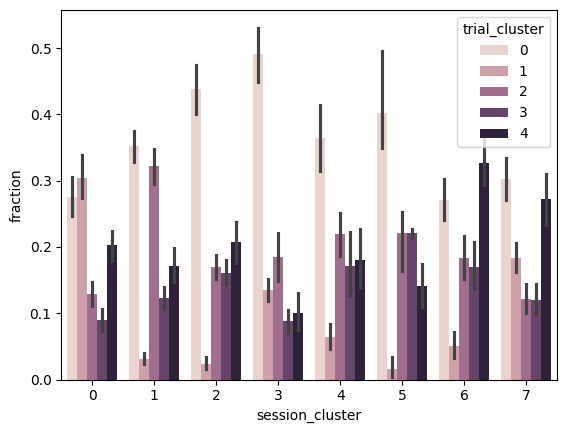

In [7]:
sns.barplot(x='session_cluster', y='fraction', hue='trial_cluster', data=fractions)

## Get sequences per trial

In [ ]:
enough_sessions = cluster_df.groupby('session_cluster')['session_cluster'].count()>10
keep_clusters = np.arange(0, 11, 1)[enough_sessions]
cluster_df = cluster_df.loc[cluster_df['session_cluster'].isin(keep_clusters)]

IndexError: boolean index did not match indexed array along axis 0; size of axis is 11 but size of corresponding boolean axis is 5

In [7]:
var_interest = 'block'
var_interest = ''
if len(var_interest) > 0:
    pivoted_df = complete_df.pivot(index=['sample', 'trial_type', 'mouse_name', 'session', var_interest], columns=['broader_label'], values='binned_sequence').reset_index().dropna()
else:
    pivoted_df = complete_df.pivot(index=['sample', 'trial_type', 'mouse_name', 'session'], columns=['broader_label'], values='binned_sequence').reset_index().dropna()
pivoted_df = pivoted_df.merge(cluster_df[['mouse_name', 'session', 'session_cluster']], on=['mouse_name', 'session'])

In [8]:
epoch_to_analyse = ['Pre-quiescence', 'Quiescence', 'Choice', 'ITI']

sequences_choice = np.vstack(pivoted_df[epoch_to_analyse].apply(lambda row: np.hstack(row), axis=1))  # Transpose to get the right shape
use_sequences = sequences_choice[~np.isnan(sequences_choice).any(axis=1)]



# use_sequences = replace_func(use_sequences)




use_states = int(max(np.unique(use_sequences)))+1
timesteps = np.shape(use_sequences)[1]
binarized = np.zeros((np.shape(use_sequences)[0], timesteps*use_states))

for t in range(timesteps):
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(range(use_states))
    encoded_arr = label_binarizer.transform(use_sequences[:, t])
    binarized[:, t*use_states:(t+1)*use_states] = encoded_arr

final_matrix = binarized.copy()

In [9]:

session_syllables = pd.DataFrame(final_matrix)
session_syllables['session'] = pivoted_df['session'].copy()
session_syllables['session_cluster'] = pivoted_df['session_cluster'].copy()
session_syllables['mouse_name'] = pivoted_df['mouse_name'].copy()
use_states = len(np.unique(use_sequences))

if len(var_interest) > 0:
    session_syllables[var_interest] = pivoted_df[var_interest].copy()
    reshaped_probs = group_by_var_interest(session_syllables, var_interest, use_states)
else:
    reshaped_probs = group_by_cluster(session_syllables, use_states)
clusters = cluster_df['session_cluster']

/tmp/ipykernel_95321/1787296850.py:46: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  reshaped_probs_cluster['syllable'][t*use_states:(t+1)*use_states] = ['000', '100', '200', '300', '400', '500', '600', '700', '010', '110',
/tmp/ipykernel_95

In [10]:
order = ['000', '010', '001', '011', '100', '110', '101', '111', '200', '210', '201', '211',
         '300', '310', '301', '311', '400', '410',  '401', '411',
         '500', '510', '501', '511', '600', '610', '601', '611',
         '700', '710', '701', '711']
labels = ['VL00', 'VL10', 'VL01', 'VL11', 'Low00', 'Low10',  'Low01', 'Low11',
         'Lowish00', 'Lowish10', 'Lowish01', 'Lowish11', 
         'LL-00', 'LL-10', 'LL-01', 'LL-11', 'LR-00', 'LR-10', 'LR-01', 'LR-11', 
         'HL-00', 'HL-10', 'HL-01', 'HL-11', 'HR-00', 'HR-10', 'HR-01', 'HR-11', 
         'H-00', 'H-10', 'H-01', 'H-11']


# order = ['000', '010', '001', '011', 
#          '100', '110', '101', '111', '200', '210', '201', '211',
#          '300', '310', '301', '311', '400', '410',  '401', '411']
# labels = ['Low00', 'Low10',  'Low01', 'Low11',
#          'Lowish00', 'Lowish10', 'Lowish01', 'Lowish11', 
#          'L-00', 'L-10', 'L-01', 'L-11', 'R-00', 'R-10', 'R-01', 'R-11',
#          'H-00', 'H-10', 'H-01', 'H-11']

rename_labels = dict(zip(np.array(order), np.array(labels)))
rename_func = np.vectorize(rename_labels.get)

In [11]:
palette_30 = create_grouped_gradient_palette(n_groups=8, shades_per_group=4, base_palette='Set2')
palette_30_list = [palette_30(i) for i in range(palette_30.N)]  # Extract colors properly

palette_16 = create_grouped_gradient_palette(n_groups=2, shades_per_group=4, base_palette='Set1')
palette_16_list = [palette_16(i) for i in range(palette_16.N)]  # Extract colors properly
state_to_color = dict(zip(order, palette_16_list))

/tmp/ipykernel_95321/2543354969.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['syllable'] = rename_func(use_data['syllable'])
/tmp/ipykernel_95321/2543354969.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['syllable'] = rename_func(use_data['syllable'])
/tmp/ipykernel_95321/2543354969.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

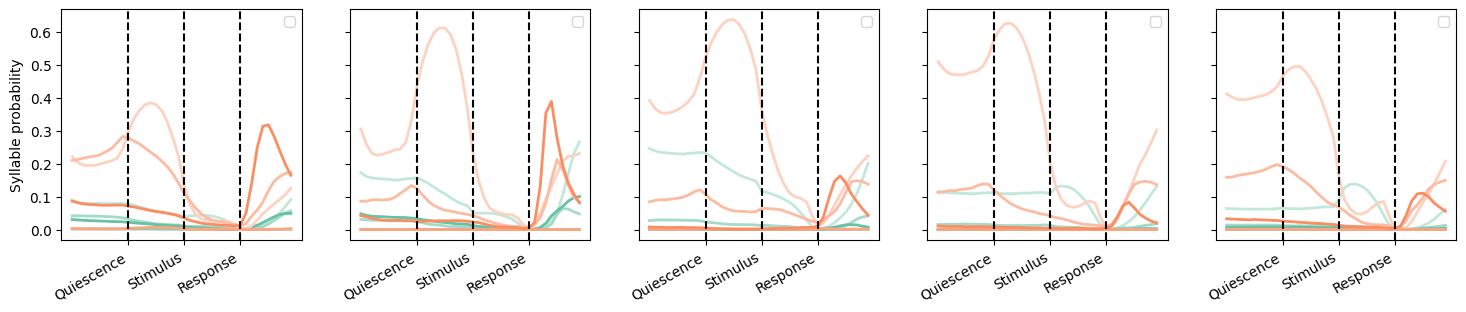

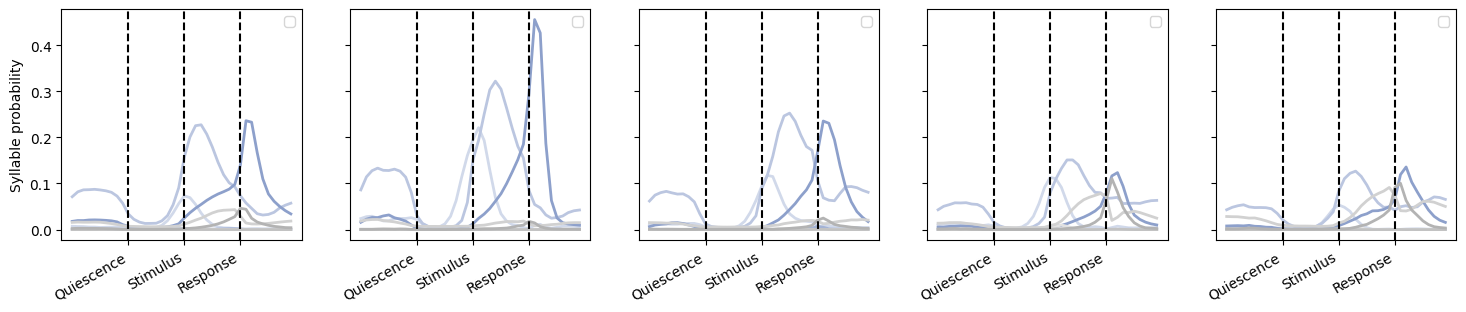

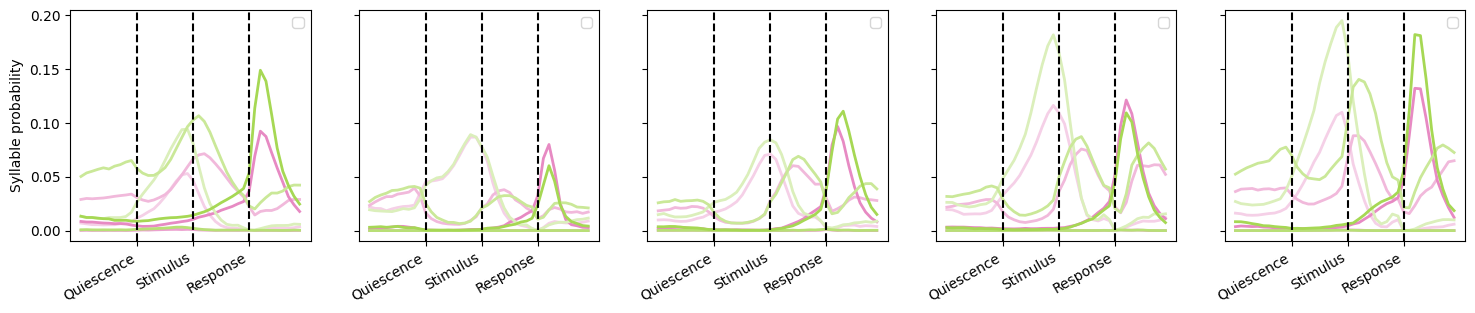

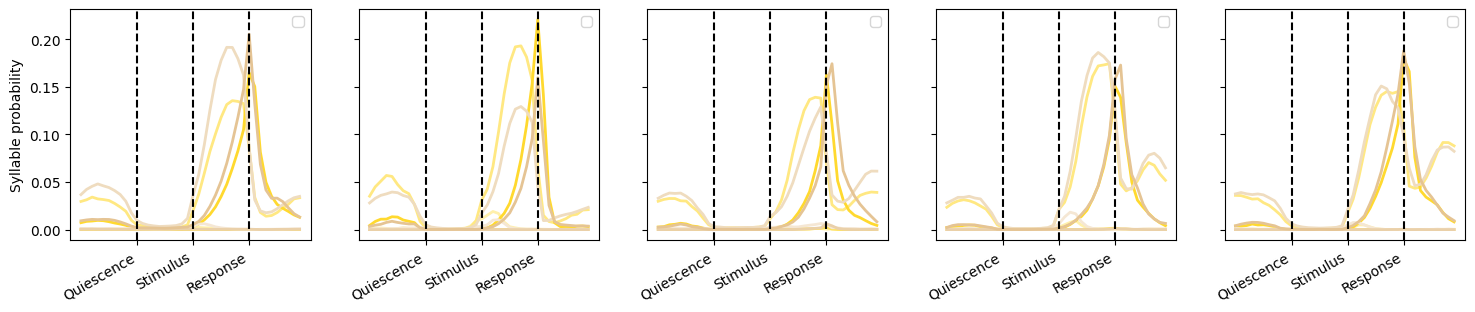

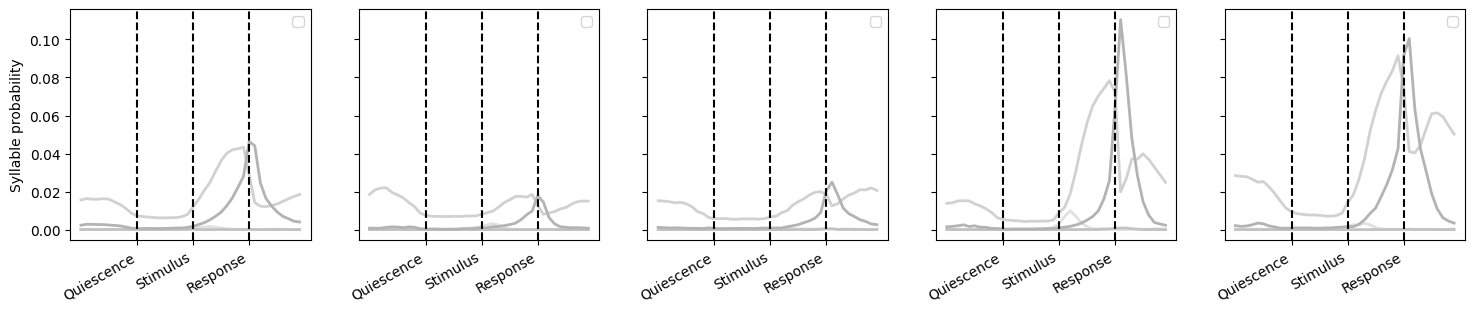

In [12]:
paw_syllable = [['VL00', 'VL10', 'VL01', 'VL11',
                'Low00', 'Low10',  'Low01', 'Low11'],
                ['Lowish00', 'Lowish10', 'Lowish01', 'Lowish11',
                  'H-00', 'H-10', 'H-01', 'H-11'],
                ['LL-00', 'LL-10', 'LL-01', 'LL-11', 'LR-00', 'LR-10', 'LR-01', 'LR-11'],
                ['HL-00', 'HL-10', 'HL-01', 'HL-11', 'HR-00', 'HR-10', 'HR-01', 'HR-11'],
                [ 'H-00', 'H-10', 'H-01', 'H-11']
                ]


# paw_syllable = [['Low00', 'Low10',  'Low01', 'Low11'],
#                 ['Lowish00', 'Lowish10', 'Lowish01', 'Lowish11'],
#                 ['L-00', 'L-10', 'L-01', 'L-11', 'R-00', 'R-10', 'R-01', 'R-11'],
#                 ['H-00', 'H-10', 'H-01', 'H-11']
#                 ]

for i in range(5):

    fig, axs = plt.subplots(1, 5, sharex=True, sharey=True, figsize=(18, 3))

    for c, cluster in enumerate(np.unique(clusters)):
        use_data = reshaped_probs.loc[reshaped_probs['cluster']==cluster]
        use_data['syllable'] = rename_func(use_data['syllable'])
        use_syllables = paw_syllable[i]
        use_data = use_data.loc[use_data['syllable'].isin(use_syllables)]
        sns.lineplot(x='timestep', y='prob', hue='syllable', data=use_data, 
                    ax=axs[c], palette=palette_30_list, hue_order=labels, linewidth=2)  #  legend=labels[c]  style=var_interest,

        axs[c].axvline(x=10, color='k', linestyle='--')
        axs[c].axvline(x=20, color='k', linestyle='--')
        axs[c].axvline(x=30, color='k', linestyle='--')
        axs[c].set_ylabel('Syllable probability')
        axs[c].set_xlabel('')
        # axs[c].set_ylim([0, 0.85])
        axs[c].set_xticks(np.arange(10, 31, 10), ['Quiescence', 'Stimulus', 'Response'], rotation=30, ha='right')
        axs[c].legend('')
# axs[c].legend(loc='upper left', bbox_to_anchor=(1.1, 1))

# Plot statistics per fingerprint

In [13]:
trials_df = complete_df.drop(columns=['broader_label', 'binned_sequence']).drop_duplicates()
# trials_df = trials_df.merge(cluster_df[['mouse_name', 'session', 'session_cluster']], on=['mouse_name', 'session'])

In [14]:
# Get timing info
data_path = prefix + 'representation_learning_variability/paper-individuality/fig1_segmentation/'
states_file = pd.read_parquet(data_path+'states_trial_type_09-29-2025')
vars = ['trial_id', 'session', 'mouse_name']
elongation = pd.DataFrame(states_file.groupby(vars)['elongation'].mean()).reset_index()
elongation['trial_id'] = elongation['trial_id'].astype(str)
response = pd.DataFrame(states_file.groupby(vars)['response'].mean()).reset_index()
response['trial_id'] = response['trial_id'].astype(str)
reaction = pd.DataFrame(states_file.groupby(vars)['reaction'].mean()).reset_index()
reaction['trial_id'] = reaction['trial_id'].astype(str)

del states_file

# Merge
trials_df = trials_df.merge(elongation, on=['session', 'trial_id', 'mouse_name'])
trials_df = trials_df.merge(response, on=['session', 'trial_id', 'mouse_name'])
trials_df = trials_df.merge(reaction, on=['session', 'trial_id', 'mouse_name'])

In [17]:
data_path = prefix + 'representation_learning_variability/DATA/'
# data_path =  '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/DATA/'
learning_df = pd.read_csv(data_path+'learning_private_one.csv')
learning_times = learning_df[['subject_nickname', 'training_time']].drop_duplicates()
learning_times = learning_times.rename(columns={"subject_nickname": "mouse_name"}).reset_index()

data_path =  prefix + 'representation_learning_variability/DATA/'
learning_df = pd.read_parquet(data_path+'training_time_03-21-2025', engine='pyarrow')
learning_times_new = learning_df.rename(columns={"subject_nickname": "mouse_name"}).reset_index()

# new_df = design_df.droplevel(1, axis=1)[['mouse_name', 'session']]
# df = new_df.merge(learning_times, on='mouse_name')
a = learning_times.merge(learning_times_new, on='mouse_name', how='outer')
b = a.loc[a['training_time_x'].isna()]
b = b.rename(columns={"training_time_y": "training_time"}).reset_index()

full_learning = pd.concat([learning_times[['mouse_name', 'training_time']], b[['mouse_name', 'training_time']]]).reset_index()

/tmp/ipykernel_6924/1096352341.py:3: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  learning_df = pd.read_csv(data_path+'learning_private_one.csv')


In [18]:
trials_df = trials_df.merge(full_learning[['mouse_name', 'training_time']], on='mouse_name')

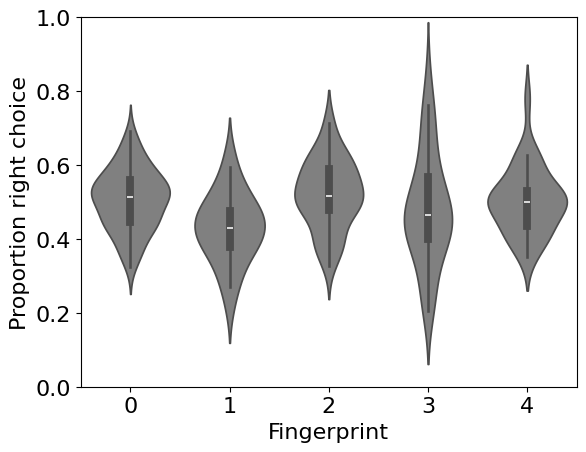

P-value for KW: 0.002
          0         1         2         3         4
0  1.000000  0.004260  1.000000  0.903079  1.000000
1  0.004260  1.000000  0.002218  0.707577  0.087805
2  1.000000  0.002218  1.000000  0.416661  1.000000
3  0.903079  0.707577  0.416661  1.000000  1.000000
4  1.000000  0.087805  1.000000  1.000000  1.000000


In [26]:
# --Machine learning and statistics
from scipy.stats import ttest_ind
from sklearn.metrics import f1_score
from scipy.stats import pearsonr
from scipy.stats import ttest_ind
import scikit_posthocs as sp
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy import stats

var_1 = 'training_time ~ session_cluster'
var = 'training_time'
var = 'choice'
var_1 = 'choice ~ session_cluster'

data = pd.DataFrame(trials_df.groupby(['mouse_name', 'session', 'session_cluster'])[var].mean()).reset_index().dropna()
# data = pd.DataFrame(trials_df.groupby(['mouse_name', 'session_cluster'])[var].mean()).reset_index().dropna()
# data = pd.DataFrame(new_df.groupby(['mouse_name', 'session_cluster'])[var].mean()).reset_index().dropna()
# data = data[['session_cluster', var]]
data[var] = data[var].astype(float)

model = ols(var_1, data=data).fit()

plt.rcParams.update({'font.size': 16})
sns.violinplot(x='session_cluster', y=var, data=data, color='grey') # , palette=sns.light_palette("seagreen", 3, as_cmap=False))
# sns.barplot(x='session_cluster', y=var, data=data, palette=sns.light_palette("seagreen", 3, as_cmap=False))
# sns.scatterplot(x='part_cluster', y=var, data=data, color='black')
# plt.xticks([0, 1, 2, 3, 4, 5], [0, 1, 2, 3, 4, 5])
plt.ylim([0, 80])
plt.ylim([0, 4])
plt.ylim([0.5, 1])
plt.ylim([0, 1])
plt.xlabel('Fingerprint')
plt.ylabel('Proportion right choice')
# plt.ylabel('Trial elongation (s)')
# plt.ylabel('Reaction time (s)')
plt.show()
    
#keep_clusters = [ 0,  2,  3,  4,  5,  6,  8, 10]
group_1 = data.loc[data['session_cluster']==0, var]
group_2 = data.loc[data['session_cluster']==1, var]
group_3 = data.loc[data['session_cluster']==2, var]
group_4 = data.loc[data['session_cluster']==3, var]
group_5 = data.loc[data['session_cluster']==4, var]
# group_6 = data.loc[data['session_cluster']==5, var]

# stat, p_value = stats.kruskal(group_1, group_2, group_3, group_4, group_5, group_6)
stat, p_value = stats.kruskal(group_1, group_2, group_3, group_4, group_5)


print(f"P-value for KW: {p_value:.3f}")

posthoc = sp.posthoc_dunn(data.dropna(), val_col=var, group_col='session_cluster', p_adjust='bonferroni')
print(posthoc)